In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from collections import namedtuple
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

from catch import Catch

from sith import SITH
from memory_hash import HashedMemory

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
print(use_cuda)

True


In [1682]:
"""
Reinforcement learning without going too deep.
"""

class SithSR(object):
    """SITH-based Successor Representation"""
    def __init__(self, state_len, action_len,
                 gamma=.5, alpha=.5, num_drifts=3, p=.2,
                 info_rate=1./30., dt=1./30./10., dur=1./30./10.,
                 dtype=np.float32):
        # save the vars
        self._dtype = dtype
        self._state_len = state_len
        self._action_len = action_len
        self._info_rate = info_rate
        self._dt = dt
        self._dur = dur
        self._delay = info_rate - dt
        self._p = p
        self._num_drifts = num_drifts

        self._gamma = gamma
        self._alpha = alpha

        self.history = None

        self._actions = torch.eye(action_len).type(FloatTensor)
        # init sith
        self._in_sith = state_len + action_len
        self._sith = SITH(self._in_sith, dt=self._dt, tau_0=self._info_rate, ntau=25, dtype=self._dtype, use_cuda=use_cuda)
        self._p0 = torch.zeros((self._state_len, 1)).type(FloatTensor)

        # allocate for M
        self._in_M = self._sith.T.size()[0]
        self._M = torch.zeros((self._state_len, self._in_M)).type(FloatTensor) # (outM, inM)

    def reset_T(self):
        self._sith.reset()
        self._p0 = torch.zeros((self._state_len, 1)).type(FloatTensor)

    def add_memory(self, reward):
        curr_history = torch.cat((self._sith.T.view(-1).unsqueeze(0),
                                  FloatTensor([reward]).unsqueeze(0)),
                                 1)
        if self.history is None:
            self.history = curr_history
        else:
            self.history = torch.cat((self.history, curr_history), 0)
            
    def pick_action(self, state):
        
        # Compress Histories (WHY DO I HAVE TO SUBTRACT 1 FROM THE SIZE OF TAUSTAR?????)
        ch = model.history[:, :-1].clone().view(model.history.size(0), 
                                                model._sith.tau_star[model._sith._T_full_ind].size-1, 
                                                model._in_sith).sum(1)[:, :-1*self._action_len]

        # Save our rewards for later
        rewards = self.history[:,-1]
        pot_action_rewards = None
        
        # Save t
        save_t = self._sith._t.clone()
        
        # Loop over actions
        for a in self._actions:
            
            # Input new state+action into SITH
            sa = torch.cat((state, a), 0)
            self._sith.update_t(sa*self._dt, dur=self._dur)
            self._sith.update_t(item=None, dur=self._delay)
            
            # Predict next states with sa, Sp
            Sp = self._M.mm(self._sith.T.view(-1, 1)).view(1, -1).expand_as(ch)
            #matshow(Sp[0].view(12,10))
            #colorbar()
            # subtract histories from Sp, creating a matrix of (histories, prediction errors)
            pe = Sp - (ch)
            # Sum all the positive prediction error and negative predition error
            w = 1./(1.+((self._p*(pe*(pe>0).type(FloatTensor))).sum(1) + (self._p - 1.)*(pe*(pe<0).type(FloatTensor)).sum(1)))

            # Multiply w by the reward and sum all values together. Add to the list of potential action rewards
            if pot_action_rewards is None:
                #pot_action_rewards = (w * rewards).sum(0).unsqueeze(0)
                pot_action_rewards = (w * rewards).max(0)[0].unsqueeze(0)
            else:
                pot_action_rewards = torch.cat((pot_action_rewards, 
                                                (w * rewards).max(0)[0].unsqueeze(0)), 
                                               0)
            # return back to previous t
            self._sith._t = save_t
            self._sith._t_changed = True
        #print(pot_action_rewards)
        action_index = pot_action_rewards.max(0)[1]

        return action_index

    def learn_step(self, state, action):
        # turn into new sa1
        sa1 = torch.cat((state, self._actions[action].view(-1)), 0).unsqueeze(1)
        sa1_p = torch.cat((sa1, torch.zeros((self._sith.T.size(0) - sa1.size(0), 1)).type(FloatTensor)), 0)
        # calc prediction from new state
        p1 = self._M.mm(sa1_p)
        # update M based on prediction error
        perr = state.unsqueeze(1) + self._gamma * p1 - self._p0
        #perr = state.unsqueeze(1) - self._p0
        self._M += self._alpha * perr.mm(self._sith.T.unsqueeze(1).t())
        
        # update T with that state action
        self._sith.update_t(item=sa1.view(-1)*self._dt, dur=self._dur)
        self._sith.update_t(item=None, dur=self._delay)

        # prepare for next loop
        self._p0 = p1


In [1749]:
# global params
height = 10
width=10
num_actions = 3
input_size = width * height

# how many games to train on every frame
games_per_frame = 10

masks = [0] #[0, 1, 2, 4, 8, 12, 16]

q_sizes = {'RL':[1]}
           #'queue': [1, 5, 10]}
mod_type = ["RL"]
num_runs = 1
model = SithSR(state_len=input_size, action_len=num_actions)

In [1750]:
run_base = 'catch_long_lr'
#run_base = 'catch_MSE'
num_games = 500
hidden_size = input_size * 1
per_random_act = .1
# set up the catch environment
c = Catch(screen_height=height, screen_width=width,
          game_over_conditions = {'ball_deletions': 1},
          mask=0, ball_spawn_rate=height+1,)

In [1751]:
tot_score = 0.0

# train over total epochs
for e in range(num_games):
    c.reset()
    model.reset_T()
    game_over = False
    # get initial input
    input_t = Tensor(c.observe(flatten=True))
    
    #iterate over each game
    while not game_over:
        # t_-1 is the previous observation
        input_tm1 = input_t.clone()


        # Randomly pick an action, or use the
        # Previously calculated action
        #if (np.random.rand() <= per_random_act) or (model.history is None):
        if (e < 500):
            action = (torch.rand(1) * (num_actions)).type(LongTensor)
        else:
            action = model.pick_action(input_tm1)

        # apply action, get rewards and new state
        reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

        # t_0, current timestep
        input_t = Tensor(c.observe(flatten=True))

        # store experience
        model.learn_step(state=input_tm1, action=action.cpu().numpy()[0])
        if reward != 0:
            model.add_memory(reward)
            tot_score += reward

        print(e, ": ", tot_score)
    # Reset Game and Model Queue when the game is over.
    

0 :  0.0
0 :  0.0
0 :  0.0
0 :  0.0
0 :  0.0
0 :  0.0
0 :  0.0
0 :  0.0
0 :  -1.0
1 :  -1.0
1 :  -1.0
1 :  -1.0
1 :  -1.0
1 :  -1.0
1 :  -1.0
1 :  -1.0
1 :  -1.0
1 :  -2.0
2 :  -2.0
2 :  -2.0
2 :  -2.0
2 :  -2.0
2 :  -2.0
2 :  -2.0
2 :  -2.0
2 :  -2.0
2 :  -3.0
3 :  -3.0
3 :  -3.0
3 :  -3.0
3 :  -3.0
3 :  -3.0
3 :  -3.0
3 :  -3.0
3 :  -3.0
3 :  -4.0
4 :  -4.0
4 :  -4.0
4 :  -4.0
4 :  -4.0
4 :  -4.0
4 :  -4.0
4 :  -4.0
4 :  -4.0
4 :  -5.0
5 :  -5.0
5 :  -5.0
5 :  -5.0
5 :  -5.0
5 :  -5.0
5 :  -5.0
5 :  -5.0
5 :  -5.0
5 :  -6.0
6 :  -6.0
6 :  -6.0
6 :  -6.0
6 :  -6.0
6 :  -6.0
6 :  -6.0
6 :  -6.0
6 :  -6.0
6 :  -5.0
7 :  -5.0
7 :  -5.0
7 :  -5.0
7 :  -5.0
7 :  -5.0
7 :  -5.0
7 :  -5.0
7 :  -5.0
7 :  -6.0
8 :  -6.0
8 :  -6.0
8 :  -6.0
8 :  -6.0
8 :  -6.0
8 :  -6.0
8 :  -6.0
8 :  -6.0
8 :  -5.0
9 :  -5.0
9 :  -5.0
9 :  -5.0
9 :  -5.0
9 :  -5.0
9 :  -5.0
9 :  -5.0
9 :  -5.0
9 :  -6.0
10 :  -6.0
10 :  -6.0
10 :  -6.0
10 :  -6.0
10 :  -6.0
10 :  -6.0
10 :  -6.0
10 :  -6.0
10 :  -5.0
11 :  -5.

92 :  -37.0
93 :  -37.0
93 :  -37.0
93 :  -37.0
93 :  -37.0
93 :  -37.0
93 :  -37.0
93 :  -37.0
93 :  -37.0
93 :  -38.0
94 :  -38.0
94 :  -38.0
94 :  -38.0
94 :  -38.0
94 :  -38.0
94 :  -38.0
94 :  -38.0
94 :  -38.0
94 :  -37.0
95 :  -37.0
95 :  -37.0
95 :  -37.0
95 :  -37.0
95 :  -37.0
95 :  -37.0
95 :  -37.0
95 :  -37.0
95 :  -38.0
96 :  -38.0
96 :  -38.0
96 :  -38.0
96 :  -38.0
96 :  -38.0
96 :  -38.0
96 :  -38.0
96 :  -38.0
96 :  -39.0
97 :  -39.0
97 :  -39.0
97 :  -39.0
97 :  -39.0
97 :  -39.0
97 :  -39.0
97 :  -39.0
97 :  -39.0
97 :  -40.0
98 :  -40.0
98 :  -40.0
98 :  -40.0
98 :  -40.0
98 :  -40.0
98 :  -40.0
98 :  -40.0
98 :  -40.0
98 :  -39.0
99 :  -39.0
99 :  -39.0
99 :  -39.0
99 :  -39.0
99 :  -39.0
99 :  -39.0
99 :  -39.0
99 :  -39.0
99 :  -40.0
100 :  -40.0
100 :  -40.0
100 :  -40.0
100 :  -40.0
100 :  -40.0
100 :  -40.0
100 :  -40.0
100 :  -40.0
100 :  -39.0
101 :  -39.0
101 :  -39.0
101 :  -39.0
101 :  -39.0
101 :  -39.0
101 :  -39.0
101 :  -39.0
101 :  -39.0
101 :  -40.

184 :  -70.0
184 :  -70.0
184 :  -71.0
185 :  -71.0
185 :  -71.0
185 :  -71.0
185 :  -71.0
185 :  -71.0
185 :  -71.0
185 :  -71.0
185 :  -71.0
185 :  -72.0
186 :  -72.0
186 :  -72.0
186 :  -72.0
186 :  -72.0
186 :  -72.0
186 :  -72.0
186 :  -72.0
186 :  -72.0
186 :  -73.0
187 :  -73.0
187 :  -73.0
187 :  -73.0
187 :  -73.0
187 :  -73.0
187 :  -73.0
187 :  -73.0
187 :  -73.0
187 :  -74.0
188 :  -74.0
188 :  -74.0
188 :  -74.0
188 :  -74.0
188 :  -74.0
188 :  -74.0
188 :  -74.0
188 :  -74.0
188 :  -73.0
189 :  -73.0
189 :  -73.0
189 :  -73.0
189 :  -73.0
189 :  -73.0
189 :  -73.0
189 :  -73.0
189 :  -73.0
189 :  -72.0
190 :  -72.0
190 :  -72.0
190 :  -72.0
190 :  -72.0
190 :  -72.0
190 :  -72.0
190 :  -72.0
190 :  -72.0
190 :  -73.0
191 :  -73.0
191 :  -73.0
191 :  -73.0
191 :  -73.0
191 :  -73.0
191 :  -73.0
191 :  -73.0
191 :  -73.0
191 :  -72.0
192 :  -72.0
192 :  -72.0
192 :  -72.0
192 :  -72.0
192 :  -72.0
192 :  -72.0
192 :  -72.0
192 :  -72.0
192 :  -73.0
193 :  -73.0
193 :  -73.0

269 :  -93.0
269 :  -93.0
269 :  -93.0
269 :  -93.0
269 :  -93.0
269 :  -93.0
269 :  -93.0
269 :  -93.0
269 :  -94.0
270 :  -94.0
270 :  -94.0
270 :  -94.0
270 :  -94.0
270 :  -94.0
270 :  -94.0
270 :  -94.0
270 :  -94.0
270 :  -95.0
271 :  -95.0
271 :  -95.0
271 :  -95.0
271 :  -95.0
271 :  -95.0
271 :  -95.0
271 :  -95.0
271 :  -95.0
271 :  -96.0
272 :  -96.0
272 :  -96.0
272 :  -96.0
272 :  -96.0
272 :  -96.0
272 :  -96.0
272 :  -96.0
272 :  -96.0
272 :  -97.0
273 :  -97.0
273 :  -97.0
273 :  -97.0
273 :  -97.0
273 :  -97.0
273 :  -97.0
273 :  -97.0
273 :  -97.0
273 :  -98.0
274 :  -98.0
274 :  -98.0
274 :  -98.0
274 :  -98.0
274 :  -98.0
274 :  -98.0
274 :  -98.0
274 :  -98.0
274 :  -99.0
275 :  -99.0
275 :  -99.0
275 :  -99.0
275 :  -99.0
275 :  -99.0
275 :  -99.0
275 :  -99.0
275 :  -99.0
275 :  -100.0
276 :  -100.0
276 :  -100.0
276 :  -100.0
276 :  -100.0
276 :  -100.0
276 :  -100.0
276 :  -100.0
276 :  -100.0
276 :  -99.0
277 :  -99.0
277 :  -99.0
277 :  -99.0
277 :  -99.0
277

359 :  -143.0
359 :  -144.0
360 :  -144.0
360 :  -144.0
360 :  -144.0
360 :  -144.0
360 :  -144.0
360 :  -144.0
360 :  -144.0
360 :  -144.0
360 :  -145.0
361 :  -145.0
361 :  -145.0
361 :  -145.0
361 :  -145.0
361 :  -145.0
361 :  -145.0
361 :  -145.0
361 :  -145.0
361 :  -146.0
362 :  -146.0
362 :  -146.0
362 :  -146.0
362 :  -146.0
362 :  -146.0
362 :  -146.0
362 :  -146.0
362 :  -146.0
362 :  -145.0
363 :  -145.0
363 :  -145.0
363 :  -145.0
363 :  -145.0
363 :  -145.0
363 :  -145.0
363 :  -145.0
363 :  -145.0
363 :  -146.0
364 :  -146.0
364 :  -146.0
364 :  -146.0
364 :  -146.0
364 :  -146.0
364 :  -146.0
364 :  -146.0
364 :  -146.0
364 :  -145.0
365 :  -145.0
365 :  -145.0
365 :  -145.0
365 :  -145.0
365 :  -145.0
365 :  -145.0
365 :  -145.0
365 :  -145.0
365 :  -146.0
366 :  -146.0
366 :  -146.0
366 :  -146.0
366 :  -146.0
366 :  -146.0
366 :  -146.0
366 :  -146.0
366 :  -146.0
366 :  -145.0
367 :  -145.0
367 :  -145.0
367 :  -145.0
367 :  -145.0
367 :  -145.0
367 :  -145.0
367 : 

452 :  -176.0
452 :  -176.0
452 :  -177.0
453 :  -177.0
453 :  -177.0
453 :  -177.0
453 :  -177.0
453 :  -177.0
453 :  -177.0
453 :  -177.0
453 :  -177.0
453 :  -178.0
454 :  -178.0
454 :  -178.0
454 :  -178.0
454 :  -178.0
454 :  -178.0
454 :  -178.0
454 :  -178.0
454 :  -178.0
454 :  -179.0
455 :  -179.0
455 :  -179.0
455 :  -179.0
455 :  -179.0
455 :  -179.0
455 :  -179.0
455 :  -179.0
455 :  -179.0
455 :  -180.0
456 :  -180.0
456 :  -180.0
456 :  -180.0
456 :  -180.0
456 :  -180.0
456 :  -180.0
456 :  -180.0
456 :  -180.0
456 :  -179.0
457 :  -179.0
457 :  -179.0
457 :  -179.0
457 :  -179.0
457 :  -179.0
457 :  -179.0
457 :  -179.0
457 :  -179.0
457 :  -180.0
458 :  -180.0
458 :  -180.0
458 :  -180.0
458 :  -180.0
458 :  -180.0
458 :  -180.0
458 :  -180.0
458 :  -180.0
458 :  -181.0
459 :  -181.0
459 :  -181.0
459 :  -181.0
459 :  -181.0
459 :  -181.0
459 :  -181.0
459 :  -181.0
459 :  -181.0
459 :  -182.0
460 :  -182.0
460 :  -182.0
460 :  -182.0
460 :  -182.0
460 :  -182.0
460 : 

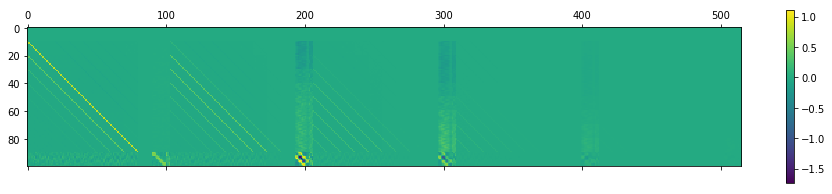

In [1752]:
matshow(model._M.cpu().numpy())
colorbar()


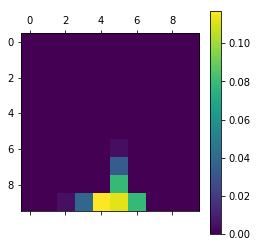

In [1753]:
matshow(model._sith.T[:100].view(10,10).cpu().numpy())
colorbar()

In [1764]:
c.reset()
model.reset_T()
input_t = Tensor(c.observe(flatten=True))


 0
[torch.cuda.LongTensor of size 1 (GPU 0)]

0


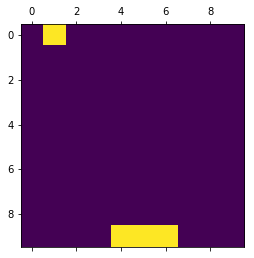

In [1765]:
#iterate over each game
# t_-1 is the previous observation
input_tm1 = input_t.clone()


# Randomly pick an action, or use the
# Previously calculated action
if (np.random.rand() <= .1) or (model.history is None):
    action = (torch.rand(1) * (num_actions)).type(LongTensor)
else:
    action = model.pick_action(input_tm1)
print(action)
# apply action, get rewards and new state
reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)
print(reward)
# t_0, current timestep
input_t = Tensor(c.observe(flatten=True))

# store experience
model.learn_step(state=input_tm1, action=action.cpu().numpy()[0])
if reward != 0:
    model.add_memory(reward)
matshow(model._sith.T[:100].view(10,10).cpu().numpy())

In [1766]:
actions = torch.eye(3).type(FloatTensor)

In [1772]:
t_save = model._sith._t.clone()

In [1773]:
sa = torch.cat((input_tm1, actions[2]), 0)
model._sith.update_t(sa*model._dt, dur=model._dur)
model._sith.update_t(item=None, dur=model._delay)


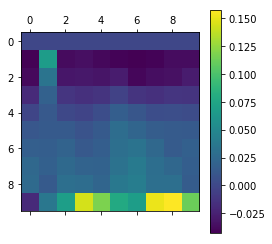

In [1774]:
matshow(model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).view(10,10).cpu().numpy())
colorbar()

In [1771]:
model._sith._t = t_save.clone()
model._sith._t_changed = True

In [1770]:
left = model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).view(10,10).cpu().numpy()


In [1775]:
right = model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).view(10,10).cpu().numpy()

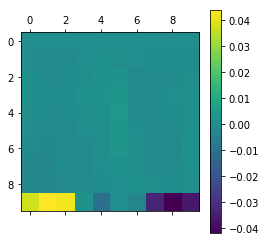

In [1778]:
matshow(left - right)
colorbar()

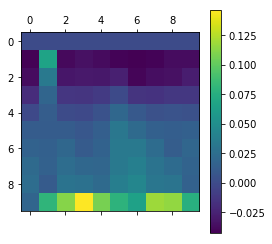

In [1779]:
matshow(left)
colorbar()

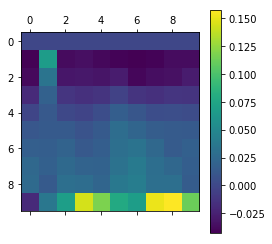

In [1780]:
matshow(right)
colorbar()

In [205]:
sith.update_t(item=sa1.view(-1), dur=1./30./10.)
sith.update_t(item=None, dur=(1./30.) - (1./30./10.))

In [206]:
reward, timestep, game_over = c.act(-1)

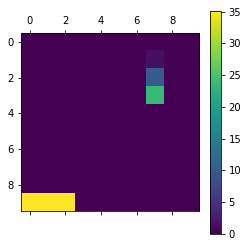

In [207]:
matshow(sith.T[0:100].view(10,10).cpu().numpy())
colorbar()

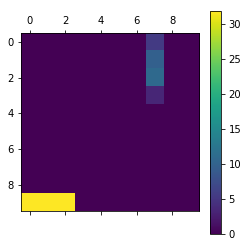

In [208]:
matshow(sith.T[103:203].view(10,10).cpu().numpy())
colorbar()

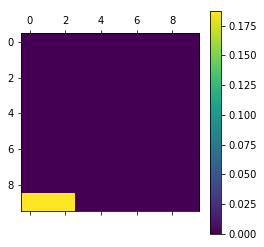

In [178]:
matshow(sith.T[206:306].view(10,10).cpu().numpy())
colorbar()

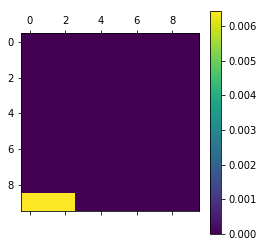

In [179]:
matshow(sith.T[309:409].view(10,10).cpu().numpy())
colorbar()

In [180]:
c.reset()

In [515]:
sith = SITH(103, dt=1./30./10., ntau=25, tau_0=1/30., dtype=np.float32, use_cuda=use_cuda)


515

In [40]:
testing = torch.eye(5).type(FloatTensor)

In [41]:
model = SithSR(state_len=5, action_len=1)

In [72]:
model.learn_step(testing[4], 0)

In [67]:
model._sith.T


 23.5166
  0.0091
  0.1207
  1.3464
 10.1742
 35.1670
  4.3522
  2.3697
  5.4488
  9.8690
 11.2486
 33.2884
  5.9313
  6.7224
  7.0543
  6.5078
  5.4633
 31.6792
  3.9863
  3.5588
  3.0496
  2.5119
  2.0013
 15.1064
  0.6671
  0.5180
  0.3874
  0.2776
  0.1892
  2.0391
[torch.FloatTensor of size 30]

In [521]:
model.history[:, :-1].clone().view(model.history.size(0), model._sith.tau_star[model._sith._T_full_ind].size-1, model._in_sith)

RuntimeError: invalid argument 2: input is not contiguous at /opt/conda/conda-bld/pytorch_1512387374934/work/torch/lib/THC/generic/THCTensor.c:227

In [535]:
model.history[:, :-1].clone().view(10, 5, 103)


( 0 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0784  0.0049  0.0339
  0.0000  0.0000  0.0000  ...   0.0205  0.0506  0.0398
  0.0000  0.0000  0.0000  ...   0.0383  0.0284  0.0310
  0.0000  0.0000  0.0000  ...   0.0180  0.0032  0.0128
  0.0000  0.0000  0.0000  ...   0.0020  0.0002  0.0013

( 1 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.1123  0.0004  0.0045
  0.0000  0.0000  0.0000  ...   0.0588  0.0191  0.0330
  0.0000  0.0000  0.0000  ...   0.0395  0.0296  0.0287
  0.0000  0.0000  0.0000  ...   0.0090  0.0086  0.0164
  0.0000  0.0000  0.0000  ...   0.0006  0.0007  0.0021

( 2 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0049  0.1123  0.0000
  0.0000  0.0000  0.0000  ...   0.0589  0.0480  0.0040
  0.0000  0.0000  0.0000  ...   0.0629  0.0058  0.0291
  0.0000  0.0000  0.0000  ...   0.0222  0.0003  0.0115
  0.0000  0.0000  0.0000  ...   0.0024  0.0000  0.0010
... 

( 7 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.1172  0.0000
  0.0000  0.0001  0.0000  ...   0.0031  0.1068  0.0010
  0.

In [540]:
sum(x for x in model.history[:, :-1].clone().view(-1) if x > 0)

18.165916631508708

In [552]:
a = model.history[:, :-1].clone()

In [557]:
a.gather(1, (a>0).type(LongTensor))



1.00000e-10 *
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  5.8336  0.0000  ...   5.8336  5.8336  5.8336
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 10x515 (GPU 0)]

In [562]:
ch = model.history[:, :-1].clone().view(model.history.size(0), 
                                                model._sith.tau_star[model._sith._T_full_ind].size-1, 
                                                model._in_sith).sum(1)[:, :-3]

In [593]:
Sp = model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).expand_as(ch)

# subtract histories from Sp, creating a matrix of (histories, prediction errors)
pe = Sp - ch/5.

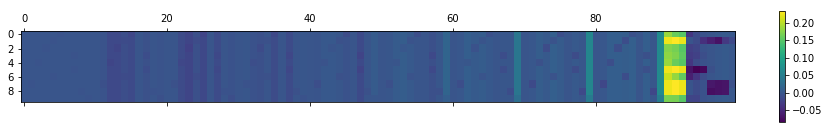

In [594]:
matshow(pe.cpu().numpy())
colorbar()

In [612]:
matshow(pe[(pe>0)].cpu().numpy())
colorbar()

ValueError: not enough values to unpack (expected 2, got 1)

In [650]:

1/(1+(p*(pe*(pe>0).type(FloatTensor)).sum(1) + (p - 1)*(pe*(pe<0).type(FloatTensor)).sum(1)))


 0.7419
 0.6623
 0.7501
 0.7345
 0.7529
 0.6498
 0.7215
 0.6504
 0.6480
 0.7674
[torch.cuda.FloatTensor of size 10 (GPU 0)]

In [652]:
p*(pe*(pe>0).type(FloatTensor)).sum(1) + (p - 1)*(pe*(pe<0).type(FloatTensor)).sum(1)


 0.3479
 0.5100
 0.3332
 0.3614
 0.3282
 0.5390
 0.3859
 0.5375
 0.5431
 0.3030
[torch.cuda.FloatTensor of size 10 (GPU 0)]